# Sentiment Analysis

### https://medium.com/@decimo.me/ควันว่างกับ-sentiment-analysis-a79b46ef9e77

In [1]:
# ใช้ตัดคำภาษาไทย
import deepcut
# ใช้งาน regex
import re
# จัดการเกี่ยวกับ array
import numpy as np
import pandas as pd
# สำหรับทำ classify และทดสอบโมเดล
from nltk import FreqDist, precision, recall, f_measure, NaiveBayesClassifier
from nltk.classify import apply_features
from nltk.classify import util
# สำหรับสร้างชุดข้อมูลสำหรับ train และ test เพื่อทดสอบประสิทธิภาพ
from sklearn.model_selection import KFold
import collections, itertools

In [2]:
import matplotlib
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
!cp thsarabunnew-webfont.ttf /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!cp thsarabunnew-webfont.ttf /usr/share/fonts/truetype/
matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='TH Sarabun New')

/bin/sh: wget: command not found
cp: directory /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf does not exist
cp: directory /usr/share/fonts/truetype does not exist


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from pythainlp import word_tokenize
from tqdm import tqdm_notebook
from pythainlp.ulmfit import process_thai

#viz
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare text for logistic regression

In [4]:
?process_thai

In [5]:
from pythainlp.ulmfit import *
process_thai("บ้านนนนน ()อยู่นานนานนาน 😂🤣😃😄😅 PyThaiNLP amp;     www.google.com")

['บ้าน',
 'xxrep',
 '  ',
 'อยู่',
 'xxwrep',
 'นาน',
 '😂',
 '🤣',
 '😃',
 '😄',
 '😅',
 'pythainlp',
 '&',
 'xxurl']

## Text files to CSVs

In [6]:
with open("wisesight-sentiment-master/kaggle-competition/train.txt") as f:
    texts = [line.strip() for line in f.readlines()]

with open("wisesight-sentiment-master/kaggle-competition/train_label.txt") as f:
    categories = [line.strip() for line in f.readlines()]

all_df = pd.DataFrame({"category":categories, "texts":texts})
all_df.to_csv('all_df.csv',index=False)
all_df.shape

(24063, 2)

In [7]:
with open("wisesight-sentiment-master/kaggle-competition/test.txt") as f:
    texts = [line.strip() for line in f.readlines()]

test_df = pd.DataFrame({"category":"test", "texts":texts})
test_df.shape

(2674, 2)

# Load data

In [8]:
all_df.head()

,category,texts
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
1,neu,คะ
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค
3,neu,😅😅😅
4,neu,สวัสดีวันพุธ แนน อะไรนะ


In [9]:
all_df['category'].unique()

array(['neu', 'neg', 'pos', 'q'], dtype=object)

In [10]:
all_df["processed"] = all_df.texts.map(lambda x: "|".join(process_thai(x)))
all_df["wc"] = all_df.processed.map(lambda x: len(x.split("|")))
all_df["uwc"] = all_df.processed.map(lambda x: len(set(x.split("|"))))

test_df["processed"] = test_df.texts.map(lambda x: "|".join(process_thai(x)))
test_df["wc"] = test_df.processed.map(lambda x: len(x.split("|")))
test_df["uwc"] = test_df.processed.map(lambda x: len(set(x.split("|"))))

# Train-Validation split

In [11]:
#when finding hyperparameters
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [12]:
valid_df.head()

,category,texts,processed,wc,uwc
0,neu,เห็นคนลบแอพ viu ก็เห็นใจและเข้าใจเขานะคะ แผลมั...,เห็น|คน|ลบ|แอ|พ|viu|ก็|เห็นใจ|และ|เข้าใจ|เขา|น...,48,43
1,neu,ไปชมไม้คิวของแชมป์ และรองแชมป์ กันจ้า! ..........,ไป|ชม|ไม้|คิว|ของ|แชมป์|และ|รอง|แชมป์|กัน|จ้า|...,43,41
2,neg,กลุ่มรถซีวิคเป็นกลุ่มที่น่ารำคานมากกกกกกกกก อว...,กลุ่ม|รถ|ซีวิค|เป็น|กลุ่ม|ที่|น่า|รำ|คาน|มาก|x...,47,36
3,neu,อยากสวยเหมือนเจ้าของแบรนด์สิคะ เนย โชติกา ใบหน...,อยาก|สวย|เหมือน|เจ้าของ|แบรนด์|สิ|คะ|เนย|โชติ|...,72,56
4,neg,ข้าวโถละร้อย แพง เพราะตักเป็นจานๆละ15 เต็มที่ก...,ข้าว|โถ|ละ|ร้อย|แพง|เพราะ|ตัก|เป็น|จาน|ๆ|ละ|15...,381,218


In [13]:
print(train_df["category"].value_counts() / train_df.shape[0])

neu    0.544957
neg    0.253557
pos    0.180071
q      0.021415
Name: category, dtype: float64


In [14]:
print(valid_df["category"].value_counts() / valid_df.shape[0])

neu    0.542659
neg    0.264266
pos    0.170914
q      0.022161
Name: category, dtype: float64


# Create model

## Logistic Model

### Create Feature

In [15]:
#dependent variables
y_train = train_df["category"]
y_valid = valid_df["category"]

In [16]:
#text faetures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(all_df["texts"])
text_train = tfidf_fit.transform(train_df["texts"])
text_valid = tfidf_fit.transform(valid_df["texts"])
text_test = tfidf_fit.transform(test_df["texts"])
text_train.shape, text_valid.shape

/Users/phatarasutarasuwan/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


((20453, 4614), (3610, 4614))

### Visualize Text

In [17]:
"""
Visualization of text data
"""

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Collection, Callable, Tuple

__all__ = ['top_feats_label', 'top_feats_all', 'plot_top_feats']

def top_feats_label(X: np.ndarray, features: Collection[str], label_idx: Collection[bool] = None,
                    min_val: float = 0.1, agg_func: Callable = np.mean)->pd.DataFrame:

    res = X[label_idx] if label_idx is not None else X
    res[res < min_val] = 0
    res_agg = agg_func(res, axis=0)
    df = pd.DataFrame([(features[i], res_agg[i]) for i in np.argsort(res_agg)[::-1]])
    df.columns = ['feature','score']
    df['ngram'] = df.feature.map(lambda x: len(set(x.split(' '))))
    return df


def top_feats_all(X: np.ndarray, y: np.ndarray, features: Collection[str], min_val: float = 0.1, 
                  agg_func: Callable = np.mean)->Collection[pd.DataFrame]:

    
    labels = np.unique(y)
    dfs = []
    for l in labels:
        label_idx = (y==l)
        df = top_feats_label(X,features,label_idx,min_val,agg_func).reset_index()
        df['label'] = l
        df.columns = ['rank','feature','score','ngram','label']
        dfs.append(df)
    return dfs


def plot_top_feats(dfs: Collection[pd.DataFrame], top_n: int = 25, ngram_range: Tuple[int,int]=(1,2),)-> None: 
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(top_n)
    for i, df in enumerate(dfs):
        sns.set(font='tahoma')
        df = df[(df.ngram>=ngram_range[0])&(df.ngram<=ngram_range[1])][:top_n]
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("score", labelpad=16, fontsize=14)
        ax.set_title(f"label = {str(df.label[0])}", fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        ax.invert_yaxis()
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [18]:
#visualize texts
# from visualize import top_feats_all, plot_top_feats
features = tfidf_fit.get_feature_names()
%time ts = top_feats_all(text_train.toarray(), y_train, features)
print(ts[0].shape)
ts[0].head()

CPU times: user 686 ms, sys: 441 ms, total: 1.13 s
Wall time: 1.13 s
(4614, 5)


,rank,feature,score,ngram,label
0,0,ไม่,0.029991,1,neg
1,1,กิน,0.022853,1,neg
2,2,xxrep,0.020253,1,neg
3,3,เลย,0.019493,1,neg
4,4,แต่,0.018151,1,neg


In [19]:
ts[1].head()

,rank,feature,score,ngram,label
0,0,#,0.021130,1,neu
1,1,xxrep,0.019556,1,neu
2,2,ครับ,0.016595,1,neu
3,3,ไป,0.015520,1,neu
4,4,ค่ะ,0.014878,1,neu


In [20]:
ts[2].head()

,rank,feature,score,ngram,label
0,0,ไป,0.036120,1,pos
1,1,กิน,0.033731,1,pos
2,2,xxrep,0.030124,1,pos
3,3,อยาก,0.030108,1,pos
4,4,ๆ,0.023815,1,pos


In [21]:
ts[3].head()

,rank,feature,score,ngram,label
0,0,คะ,0.069230,1,q
1,1,ไหม,0.044197,1,q
2,2,มี,0.043878,1,q
3,3,ครับ,0.042197,1,q
4,4,ค่ะ,0.039745,1,q


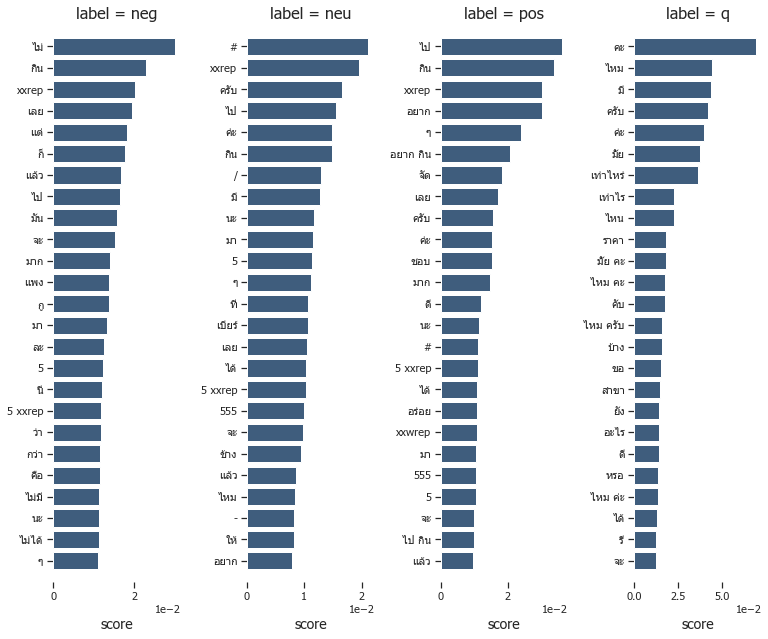

CPU times: user 646 ms, sys: 37.9 ms, total: 684 ms
Wall time: 677 ms


In [22]:
%time plot_top_feats(ts)

In [23]:
all_df.head()

,category,texts,processed,wc,uwc
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,ประเทศ|เรา|ผลิต|และ|ส่งออก|ยาสูบ|เยอะ|สุด|ใน|โ...,13,13
1,neu,คะ,คะ,1,1
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค,อิ|เหี้ย|ออม|ทำ|กู|อยาก|กิน|เอ็ม|เค,9,9
3,neu,😅😅😅,xxwrep|😅,2,2
4,neu,สวัสดีวันพุธ แนน อะไรนะ,สวัสดี|วัน|พุธ|แนน|อะไร|นะ,6,6


In [24]:
#word count and unique word counts; actually might not be so useful
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(all_df[["wc","uwc"]].astype(float))
print(scaler_fit.mean_, scaler_fit.var_)
num_train = scaler_fit.transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler_fit.transform(valid_df[["wc","uwc"]].astype(float))
num_test = scaler_fit.transform(test_df[["wc","uwc"]].astype(float))
num_train.shape, num_valid.shape

[21.96762665 18.23010431] [1152.16588876  513.90154646]


((20453, 2), (3610, 2))

In [25]:
#concatenate text and word count features
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
X_test = np.concatenate([num_test,text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

((20453, 4616), (3610, 4616))

## Fit model

In [26]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

0.7324099722991689

In [27]:
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(X_valid)
probs_df["category"] = valid_df.category
probs_df["texts"] = valid_df.texts
probs_df["processed"] = valid_df.processed
probs_df["wc"] = valid_df.wc
probs_df["uwc"] = valid_df.uwc
probs_df["hit"] = (probs_df.preds==probs_df.category)
probs_df.to_csv("probs_df_linear.csv", index=False)

0.7324099722991689


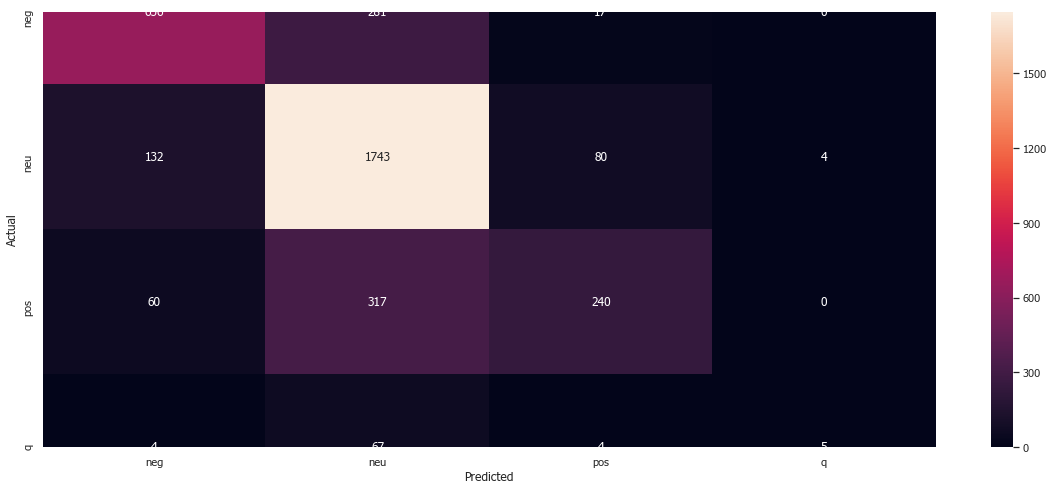

In [28]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(probs_df.category,probs_df.preds)
print(model.score(X_valid,y_valid))
plt.figure(figsize=(20,8))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Predict with Twitter data

## Load data

In [29]:
gov = pd.read_csv('government.csv', names= ('category','date','text'))
gov.head()

,category,date,text
0,NaN,4/5/2020 09:03,ได้ข่าวว่าจะชุมนุมใหญ่ ขับไล่รัฐบาลจะบอกว่ารัฐ...
1,NaN,4/5/2020 09:03,เชิงเทียนฉันมาแล้ว งดด่ารัฐบาลแป้บขอกรี้ดก่อน
2,NaN,4/5/2020 09:02,เขาชม เพราะชาวบ้านบริจาคอาหารช่วยเหลือค่ะ ไม่ใ...
3,NaN,4/5/2020 09:01,โรงเรียนมัธยมในเวียดนามเปิดเรียนอีกครั้งวันนี้...
4,NaN,4/5/2020 09:01,รัฐบาลอิตาลีอนุญาตให้ 20 สโมสรในลีกสูงสุดของปร...


In [30]:
gov.drop(columns = 'date', inplace = True)
gov.fillna('test', inplace = True)

In [31]:
gov.head()

,category,text
0,test,ได้ข่าวว่าจะชุมนุมใหญ่ ขับไล่รัฐบาลจะบอกว่ารัฐ...
1,test,เชิงเทียนฉันมาแล้ว งดด่ารัฐบาลแป้บขอกรี้ดก่อน
2,test,เขาชม เพราะชาวบ้านบริจาคอาหารช่วยเหลือค่ะ ไม่ใ...
3,test,โรงเรียนมัธยมในเวียดนามเปิดเรียนอีกครั้งวันนี้...
4,test,รัฐบาลอิตาลีอนุญาตให้ 20 สโมสรในลีกสูงสุดของปร...


In [32]:
texts = []
del_word = ['@','\n',' ','']
for i in gov['text']:
    i = str(i)
    i.lower()
    if i not in del_word:
        texts.append(i)
texts

['ได้ข่าวว่าจะชุมนุมใหญ่ ขับไล่รัฐบาลจะบอกว่ารัฐบาล รับมือโควิดได้ดี เเบบนี้ก็ได้หรือวะ เเค่เพราะพวกกุไม่ได้เป็นรัฐบาลต้องไล่ คนชั่วช้าสารเลว บ้านเมืองมีวิกฤติพยายามจะซ้ำเติม คุยใหญ่คุยโตรัฐบาลกลัวม็อบ มีเหี้ยไรที่เขาต้องกลัว ออกไปทำเหี้ยไรได้นอกจากไปนั่งฟังเเกนนำเห่า 555',
 'เชิงเทียนฉันมาแล้ว งดด่ารัฐบาลแป้บขอกรี้ดก่อน',
 'เขาชม เพราะชาวบ้านบริจาคอาหารช่วยเหลือค่ะ ไม่ใช่เพราะรัฐบาลหน้าโง่ โปรดแยกแยะด้วยค่ะ อิสลิ่ม ',
 'โรงเรียนมัธยมในเวียดนามเปิดเรียนอีกครั้งวันนี้ (4 พ.ค.) หลังรัฐบาลสั่งปิดมานานกว่า 3 เดือน สกัด #โควิด19\n\nวันนี้ ไม่พบผู้ติดเชื้อใหม่ในประเทศติดต่อกันเป็นวันที่ 17 แล้ว\n\nภาพจาก AFP \n\n#PPTVHD36 #เราไม่ทิ้งกัน #COVID19 ',
 'รัฐบาลอิตาลีอนุญาตให้ 20 สโมสรในลีกสูงสุดของประเทศ เรียกนักเตะทีมชุดใหญ่กลับมาเริ่มซ้อมที่สโมสรได้ตั้งแต่วันจันทร์นี้ &gt; ',
 '@THaWa85736827 @Exo_kim_monster @RedBuffaloFre @apple47719152 @Pannika_FWP รัฐบาลแจกถ้วนหน้าไหมล่ะ อีควาย',
 'หลังจากที่รัฐบาลของประธานาธิบดีโดนัลด์ ทรัมป์ พยายามจะหาหนทางเพื่อลงโทษจีนที่เป็นต้นตอที่ทำให้เกิดโรคโควิด-19

In [33]:
gov['text'] = texts

In [34]:
gov["processed"] = gov.text.map(lambda x: "|".join(process_thai(x)))
gov["wc"] = gov.processed.map(lambda x: len(x.split("|")))
gov["uwc"] = gov.processed.map(lambda x: len(set(x.split("|"))))

In [35]:
#prevalence
gov.category.value_counts() / all_df.shape[0]

test    0.049578
Name: category, dtype: float64

In [36]:
gov.head()

,category,text,processed,wc,uwc
0,test,ได้ข่าวว่าจะชุมนุมใหญ่ ขับไล่รัฐบาลจะบอกว่ารัฐ...,ได้ข่าว|ว่า|จะ|ชุมนุม|ใหญ่|ขับไล่|รัฐบาล|จะ|บอ...,63,52
1,test,เชิงเทียนฉันมาแล้ว งดด่ารัฐบาลแป้บขอกรี้ดก่อน,เชิงเทียน|ฉัน|มา|แล้ว|งด|ด่า|รัฐบาล|แป้บ|ขอก|ร...,12,12
2,test,เขาชม เพราะชาวบ้านบริจาคอาหารช่วยเหลือค่ะ ไม่ใ...,เขา|ชม|เพราะ|ชาวบ้าน|บริจาค|อาหาร|ช่วยเหลือ|ค่...,19,17
3,test,โรงเรียนมัธยมในเวียดนามเปิดเรียนอีกครั้งวันนี้...,โรงเรียนมัธยม|ใน|เวียดนาม|เปิดเรียน|อีกครั้ง|ว...,56,45
4,test,รัฐบาลอิตาลีอนุญาตให้ 20 สโมสรในลีกสูงสุดของปร...,รัฐบาล|อิตาลี|อนุญาต|ให้|20|สโมสร|ใน|ลีก|สูงสุ...,27,26


## Independent valiable

In [37]:
y_gov = gov['category']

## TFIDF

In [38]:
tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(all_df["texts"])
text_gov = tfidf_fit.transform(gov["text"])
text_gov.shape

/Users/phatarasutarasuwan/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(1193, 4614)

In [39]:
#visualize texts
# from visualize import top_feats_all, plot_top_feats
features = tfidf_fit.get_feature_names()
%time ts = top_feats_all(text_gov.toarray(), y_gov, features)
print(ts[0].shape)
ts[0].head(10)

CPU times: user 56.5 ms, sys: 38.2 ms, total: 94.7 ms
Wall time: 94.4 ms
(4614, 5)


,rank,feature,score,ngram,label
0,0,รัฐบาล,0.269242,1,test
1,1,@,0.091056,1,test
2,2,เงิน,0.031105,1,test
3,3,ก็,0.030336,1,test
4,4,ประชาชน,0.029744,1,test
5,5,ด่า,0.028952,1,test
6,6,คน,0.026509,1,test
7,7,ที่,0.021666,1,test
8,8,โค,0.020626,1,test
9,9,จะ,0.020230,1,test


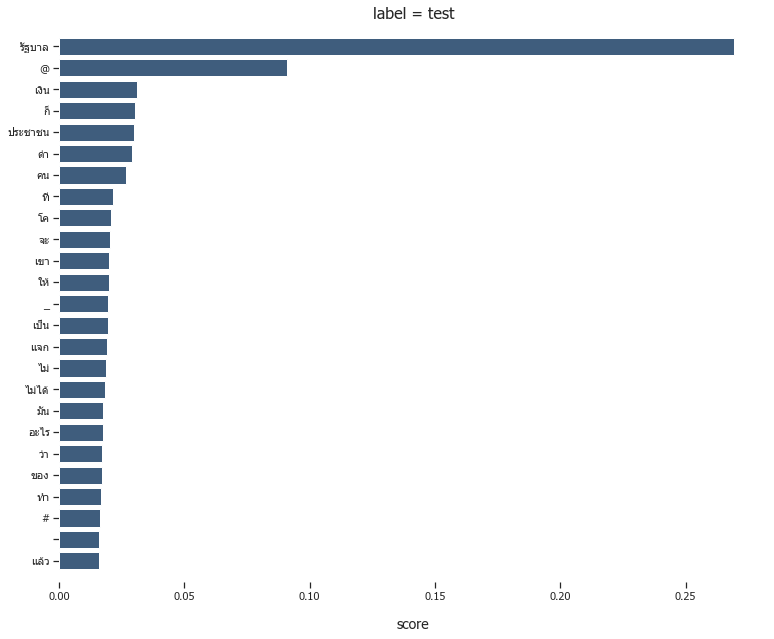

CPU times: user 238 ms, sys: 12.9 ms, total: 251 ms
Wall time: 248 ms


In [40]:
%time plot_top_feats(ts)

## Preprocessing

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(all_df[["wc","uwc"]].astype(float))
print(scaler_fit.mean_, scaler_fit.var_)

num_gov = scaler_fit.transform(gov[["wc","uwc"]].astype(float))
num_gov.shape

[21.96762665 18.23010431] [1152.16588876  513.90154646]


(1193, 2)

In [42]:
X_gov = np.concatenate([num_gov,text_gov.toarray()],axis=1)
X_gov.shape

(1193, 4616)

# Fit model

In [43]:
probs = model.predict_proba(X_gov)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(X_gov)
probs_df["category"] = gov.category
probs_df["texts"] = gov.text
probs_df["processed"] = gov.processed
probs_df["wc"] = gov.wc
probs_df["uwc"] = gov.uwc
# probs_df["hit"] = (probs_df.preds==probs_df.category)
probs_df.to_csv("probs_df_linear_gov.csv", index=False)

## Visualize result

In [44]:
result = pd.read_csv('probs_df_linear_gov.csv')
result.head(2)

,neg,neu,pos,q,preds,category,texts,processed,wc,uwc
0,0.728217,0.255209,0.013518,0.003056,neg,test,ได้ข่าวว่าจะชุมนุมใหญ่ ขับไล่รัฐบาลจะบอกว่ารัฐ...,ได้ข่าว|ว่า|จะ|ชุมนุม|ใหญ่|ขับไล่|รัฐบาล|จะ|บอ...,63,52
1,0.388821,0.557757,0.045353,0.008069,neu,test,เชิงเทียนฉันมาแล้ว งดด่ารัฐบาลแป้บขอกรี้ดก่อน,เชิงเทียน|ฉัน|มา|แล้ว|งด|ด่า|รัฐบาล|แป้บ|ขอก|ร...,12,12


In [45]:
pred = result['preds']

In [46]:
result[['texts','preds']].groupby(['preds']).count()

,texts
preds,
neg,519
neu,657
pos,16
q,1


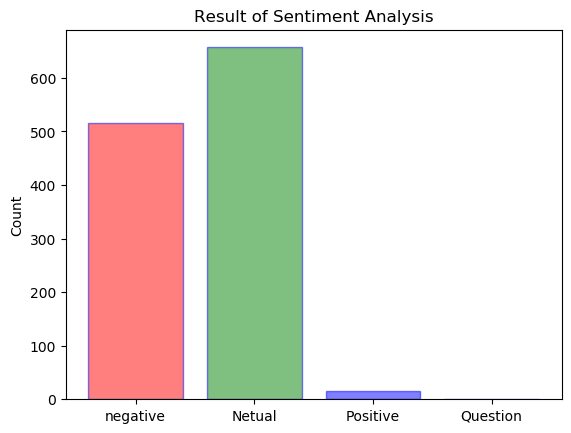

In [47]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('negative', 'Netual', 'Positive', 'Question')
y_pos = np.arange(len(objects))
performance = [516,657,16,1]

plt.bar(y_pos, performance, align='center', alpha=0.5,
        color=('red', 'green', 'blue', 'cyan'),  edgecolor='blue')
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Result of Sentiment Analysis')

plt.show()